# 3.2 - TF symbolic engine 

In [1]:
!wget -nc --no-cache -O init.py -q https://raw.githubusercontent.com/rramosp/2021.deeplearning/main/content/init.py
import init; init.init(force_download=False); 

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%load_ext tensorboard

from sklearn.datasets import *
from local.lib import mlutils
from IPython.display import Image
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'2.1.0'

## Tensorflow Dev Summit

the following images are screenshots of the publicly available material from conferences at the [TensorFLow Dev Summit](https://www.tensorflow.org/dev-summit)

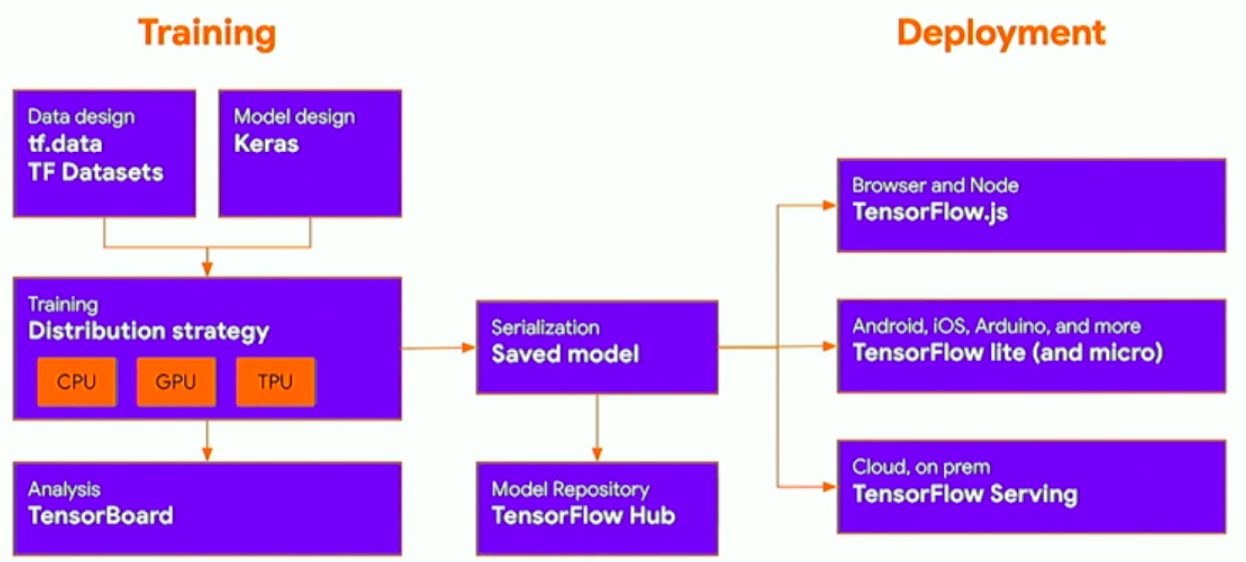

In [4]:
Image("local/imgs/tfCycle.png")

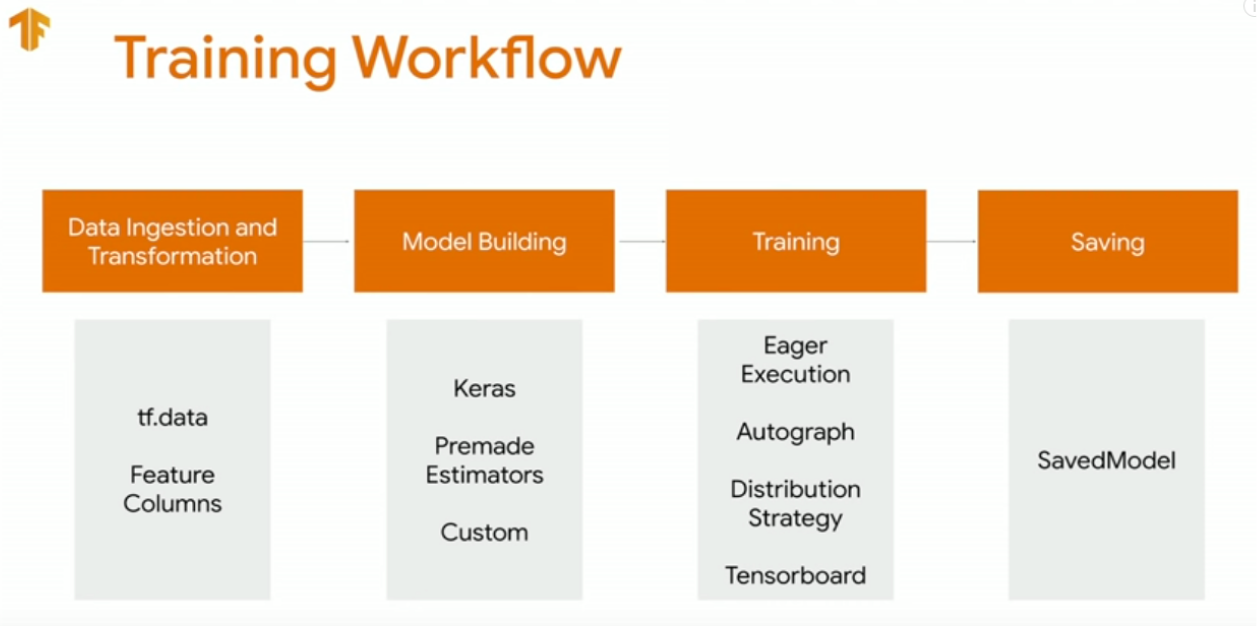

In [5]:
Image("local/imgs/tfTrainingWorkflow.png")

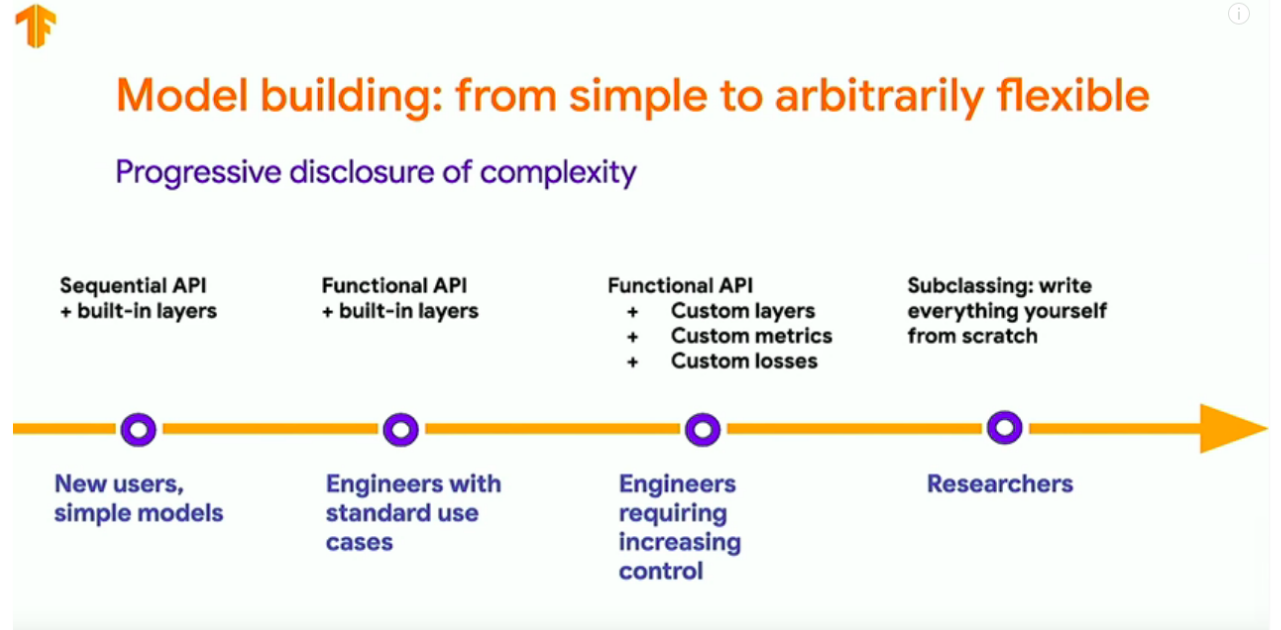

In [6]:
Image("local/imgs/tfAPIs.png")

## TF is a symbolic computing + optimization library for machine learning problems

ML expressions involve:

- variables representing data as n-dimensional objects
- variables representing parameters as n-dimensional objects
- mostly matrix operations (multiplications, convolutions, etc.)
- some non linear operations (activation functions)


**Recall** that in `sympy` we **FIRST** define expressions (a computational graph) and **THEN** we evaluate them feed concrete values.

Tensorflow **INTEGRATES** both aspects so that building computational graphs **LOOKS LIKE** writing regular Pytohn code as must as possible.

- a `tf.Variable` represents a **symbolic** variable, that **contains a value**


See:

- https://www.tensorflow.org/guide/keras/train_and_evaluate
- https://www.tensorflow.org/guide/keras/custom_layers_and_models
- https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

In [7]:
x = tf.Variable(initial_value=[7], name="x", dtype=tf.float32)
y = tf.Variable(initial_value=[9], name="y", dtype=tf.float32)
f = x**2+y**3
f

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([778.], dtype=float32)>

for which TF can obtain gradients automatically

In [8]:
with tf.GradientTape(persistent=True) as t:
    f = x**2 + y**3
    
print (t.gradient(f, x), t.gradient(f, y))
    

tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


usually expressions are built within functions decorated with `@tf.function` for performance

In [9]:
@tf.function
def myf(x,y):
    return x**2 + y**3

In [10]:
with tf.GradientTape(persistent=True) as t:
    f = myf(x,y)
    
print (t.gradient(f, x), t.gradient(f, y))


tf.Tensor([14.], shape=(1,), dtype=float32) tf.Tensor([243.], shape=(1,), dtype=float32)


In [11]:
!rm -rf logs
mlutils.make_graph(myf, x, y, logdir="logs")


In [12]:
%tensorboard --logdir logs

## Implementing linear regresion in TF


(150, 1) (150,)


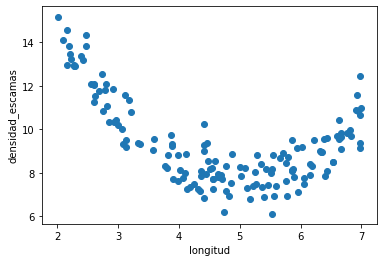

In [13]:
d = pd.read_csv("local/data/trilotropicos.csv")
y = d.densidad_escamas.values.astype(np.float32)
X = np.r_[[d.longitud.values]].T.astype(np.float32)

print(X.shape, y.shape)
plt.scatter(d.longitud, d.densidad_escamas)
plt.xlabel(d.columns[0])
plt.ylabel(d.columns[1]);

 ## Version 1: raw low level with gradient descent
 
- beware of typing. `tensorflow` is very sensitive to numeric data types (`tf.float32`, `tf.float64`, etc.) Default types in `numpy` and `tensorflow` might not always be the same

In [14]:
from progressbar import progressbar as pbar

epochs = 4000
learning_rate = 0.01

# symbolic variables
w = tf.Variable(np.random.normal(size=(X.shape[-1], 1), scale=.6), dtype=tf.float32)
b = tf.Variable(np.random.normal(size=(1,), scale=.6), dtype=tf.float32)
h = []

#optimization loop
for epoch in pbar(range(epochs)):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y.reshape(-1,1))**2)
        
    gw, gb = t.gradient(loss, [w, b])
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)
    
    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


[12.677704] [[-0.7156436]]


(0, 50)

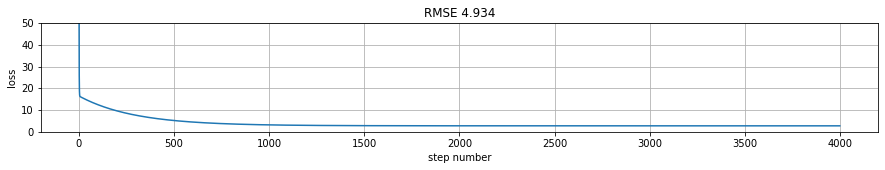

In [15]:
rmse = tf.reduce_mean((tf.matmul(X,w)+b-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 2: using `tf.function`

In [16]:
epochs = 4000

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1)).astype(np.float32)*.6) 
b.assign(np.random.normal(size=(1,)).astype(np.float32))

@tf.function
def get_gradient(w, b, X, y):
    with tf.GradientTape() as t:
        preds = tf.matmul(X,w)+b
        loss = tf.reduce_mean( (preds-y)**2)
        
    gw, gb = t.gradient(loss, [w, b])
    return gw, gb, loss

#optimization loop
h = []
for epoch in pbar(range(epochs)):
        
    gw, gb, loss = get_gradient(w, b, X, y.reshape(-1,1))
    
    w.assign_sub(learning_rate * gw)
    b.assign_sub(learning_rate * gb)

    h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]

print (b.numpy(), w.numpy())

100% (4000 of 4000) |####################| Elapsed Time: 0:00:02 Time:  0:00:02


[12.677471] [[-0.7155976]]


(0, 50)

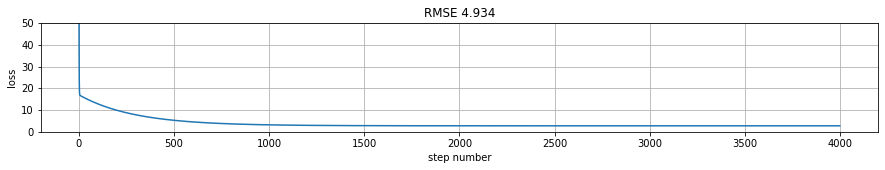

In [17]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 3: using batches with random shuffling (stochastic gradient descent)

notice we tune the number of epochs as the number of weights updates increases

In [18]:
#optimization loop
batch_size = 16
epochs = 400

# initialize weights
w.assign(np.random.normal(size=(X.shape[-1],1))*.6) 
b.assign(np.random.normal(size=(1,)))

h = []

for epoch in pbar(range(epochs)):
    
    idxs = np.random.permutation(len(X))
    
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]
        
        gw, gb, loss = get_gradient(w, b, X_batch, y_batch.reshape(-1,1))

        w.assign_sub(learning_rate * gw)
        b.assign_sub(learning_rate * gb)
        
        h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
h = np.r_[h]
print (b.numpy(), w.numpy())

100% (400 of 400) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


[12.658868] [[-0.77054477]]


(0, 50)

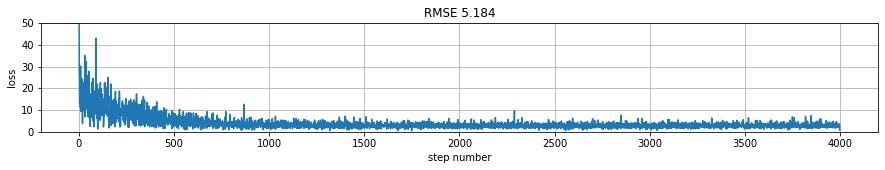

In [19]:
predictions = tf.matmul(X,w)+b

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 4: packing up with Keras `class` API  and custom SGD

observe:

- the`build` method that is called by Keras whenever `input_shape` is known
- we use `add_weight` so that our model weights are known to the Keras model framework (`trainable_variables`, `get_weights`, etc.) 

see [here](https://www.tensorflow.org/guide/keras/custom_layers_and_models)

In [125]:
class LinearRegression(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
        self.b = self.add_weight(shape=(1,), initializer='random_normal',
                                 trainable=True, dtype=tf.float32)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b
    
    @tf.function
    def get_gradient(self, X, y):
        with tf.GradientTape() as t:
            loss = tf.reduce_mean( (self(X)-y)**2)

        gw, gb = t.gradient(loss, [self.w, self.b])
        return gw, gb, loss

    def fit(self, X,y, epochs, batch_size=16, learning_rate=0.01):
        y = y.reshape(-1,1)
        self.h=[]
        for epoch in pbar(range(epochs)):
            idxs = np.random.permutation(len(X))
            for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
                X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
                y_batch = y[idxs][step*batch_size:(step+1)*batch_size]            

                gw, gb, loss = self.get_gradient(X_batch,y_batch)
                self.w.assign_sub(learning_rate * gw)
                self.b.assign_sub(learning_rate * gb)
                self.h.append([gw.numpy()[0][0], gb.numpy()[0], w.numpy()[0][0], b.numpy()[0], loss.numpy()])
        self.h = np.r_[self.h]


In [126]:
lr = LinearRegression()

observe that we can use the object directly on data to get predictions

In [127]:
lr(X[:2])

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[-0.11625272],
       [-0.07879776]], dtype=float32)>

or with the  `.predict` method

In [128]:
lr.predict(X[:2])

array([[-0.11625272],
       [-0.07879776]], dtype=float32)

In [129]:
lr.trainable_variables

[<tf.Variable 'linear_regression_11/Variable:0' shape=(1, 1) dtype=float32, numpy=array([[-0.02252782]], dtype=float32)>,
 <tf.Variable 'linear_regression_11/Variable:0' shape=(1,) dtype=float32, numpy=array([-0.03025964], dtype=float32)>]

In [130]:
lr.get_weights()

[array([[-0.02252782]], dtype=float32), array([-0.03025964], dtype=float32)]

and fit the model

In [26]:
lr.fit(X, y, epochs=400, batch_size=16)

100% (400 of 400) |######################| Elapsed Time: 0:00:02 Time:  0:00:02


In [27]:
lr.b.numpy(), lr.w.numpy()

(array([12.682179], dtype=float32), array([[-0.7454917]], dtype=float32))

(0, 50)

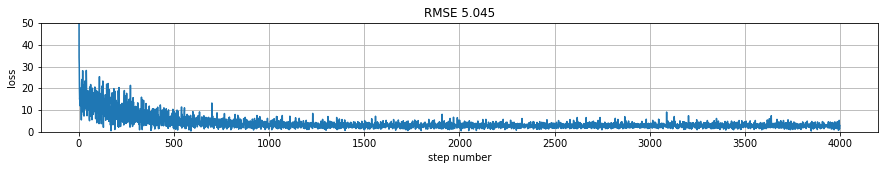

In [28]:
predictions = lr(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(lr.h[:,-1]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 5: Sequential Keras model with standard loop

In [29]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  loss="mse")
    return model

In [30]:
model = get_model()
model.fit(X,y, epochs=400, batch_size=16, verbose=0)
model.weights

[<tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.79932135]], dtype=float32)>,
 <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([12.644618], dtype=float32)>]

history is now logged only per epoch

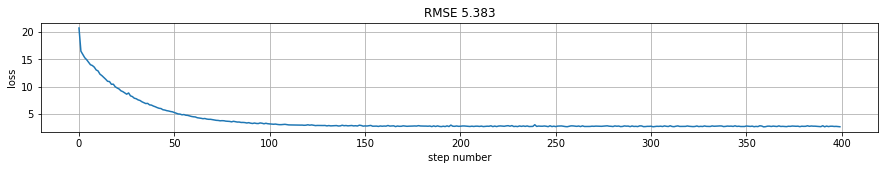

In [31]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);

## Version 6: Model with Keras `class` API  and standard loop

In [32]:
class LinearRegression(tf.keras.Model):
    
    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='random_normal',
                                 trainable=True)
        
        self.b = self.add_weight(shape=(1,),
                                 initializer='random_normal',
                                 trainable=True)
        
    def call(self, inputs):
        return tf.matmul(inputs, self.w) + self.b


In [33]:
lr = LinearRegression()
lr.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
           loss="mse")
lr.fit(X,y, epochs=400, batch_size=16, verbose=0)

In [34]:
lr.b.numpy(), lr.w.numpy()[0]


(array([12.652356], dtype=float32), array([-0.6723846], dtype=float32))

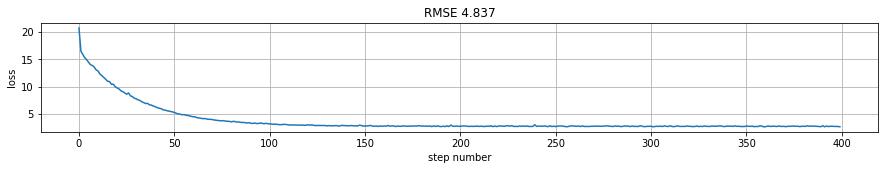

In [35]:
predictions = lr(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(model.history.history["loss"]); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);

## Version 7: Keras sequential model with custom loop but using model loss + optimizer

observe how we use the loss functions and `optimizer.apply_gradients`

In [36]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
    
def get_model():
    model = Sequential()
    model.add(Dense(1, input_shape=(X.shape[-1],), activation="linear"))
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), 
                  loss="mse")
    return model

our custom loop (**for any model** !!!)

In [73]:
epochs = 400
batch_size = 16

model = get_model()
loss = model.loss_functions[0].fn
optimizer = model.optimizer

In [74]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.8351266]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [75]:
model.trainable_variables

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.8351266]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

In [76]:
@tf.function
def train_step(X,y):
    with tf.GradientTape() as tape:
        loss_value = tf.reduce_mean(loss(model(X), y))
    grads = tape.gradient(loss_value, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return loss_value

h = []
for epoch in pbar(range(epochs)):
    idxs = np.random.permutation(len(X))
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]       
        loss_value = train_step(X_batch, y_batch)
    h.append(loss_value)

100% (400 of 400) |######################| Elapsed Time: 0:00:01 Time:  0:00:01


In [77]:
model.weights

[<tf.Variable 'dense_2/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-0.01759887]], dtype=float32)>,
 <tf.Variable 'dense_2/bias:0' shape=(1,) dtype=float32, numpy=array([9.567637], dtype=float32)>]

(0, 50)

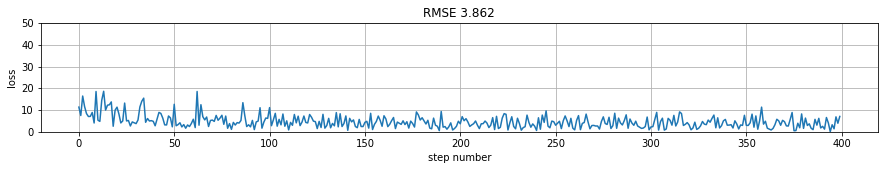

In [78]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);
plt.ylim(0,50)

## Version 8: using `train_on_batch`

In [81]:
model = get_model()
h = []
for epoch in pbar(range(epochs)):
    idxs = np.random.permutation(len(X))
    for step in range(len(X)//batch_size+((len(X)%batch_size)!=0)):
        X_batch = X[idxs][step*batch_size:(step+1)*batch_size]
        y_batch = y[idxs][step*batch_size:(step+1)*batch_size]       
        model.train_on_batch(X_batch, y_batch)
    h.append(model.loss_functions[0](model(X_batch), y_batch).numpy())

100% (400 of 400) |######################| Elapsed Time: 0:00:03 Time:  0:00:03


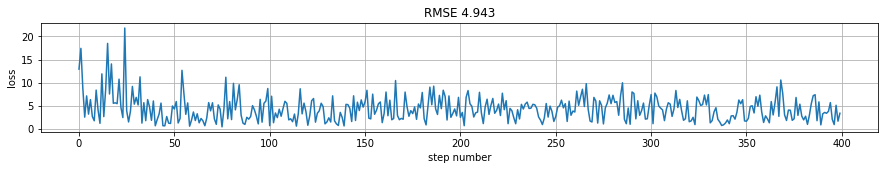

In [82]:
predictions = model(X)

rmse = tf.reduce_mean((predictions-y)**2).numpy()
plt.figure(figsize=(15,2));
plt.plot(h); plt.xlabel("step number"); plt.ylabel("loss"); plt.grid();
plt.title("RMSE %.3f"%rmse);